In [ ]:
# Imports
import tensorflow
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, MaxPool2D, Conv2D, UpSampling2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

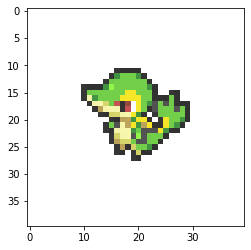

In [ ]:
# Load data
x_train = np.load("/content/drive/MyDrive/Colab Notebooks/Datasets/Pokemon_Data.npy")

plt.imshow(x_train[715])
plt.show()

In [ ]:
# Dataset settings
D = x_train.shape[0]
W = x_train.shape[1]
H = x_train.shape[2]
d = x_train.shape[3]

latent_dim = 256

print(x_train.shape)

(891, 40, 40, 3)


In [ ]:
# Create the model
def create_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
    x = Reshape(target_shape=(4, 4, 64))(x)
    x = Conv2D(32, (2, 2), activation=LeakyReLU(alpha=0.2))(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, (2, 2), activation=LeakyReLU(alpha=0.2))(x)
    x = UpSampling2D()(x)
    x = Flatten()(x)
    x = Dense(2400, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(4800, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(4800, activation="sigmoid")(x)
    x = Reshape(target_shape=(40, 40, 3))(x)

    model = Model(i, x)
    return model

In [ ]:
def create_discriminator(image_shape):
    i = Input(shape=(image_shape))
    x = Conv2D(8, (2, 2), activation=LeakyReLU(alpha=0.2))(i)
    x = MaxPool2D()(x)
    x = Conv2D(16, (2, 2), activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPool2D()(x)
    x = Conv2D(32, (2, 2), activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(i, x)
    return model

In [ ]:
# Compile the models
generator = create_generator(latent_dim)
discriminator = create_discriminator(x_train[0].shape)

discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=["accuracy"]
)

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False

fake_pred = discriminator(img)

gan = Model(z, fake_pred)
gan.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5)
)

# print(generator.summary())
# print(discriminator.summary())
# print(gan.summary())

In [ ]:
# Config for training the models
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

image_path = "/content/drive/My Drive/Colab Notebooks/Outputs/Pokemon Gan"

if not os.path.exists(image_path):
    os.mkdir(image_path)

In [ ]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W, d), cmap="gray")
            axs[i, j].axis("off")
            idx += 1
    fig.savefig(image_path + "/%d.png" % epoch)
    plt.close()

In [ ]:
# Main train loop
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train discriminator
    d_loss, d_acc = discriminator.train_on_batch(np.concatenate(real_imgs, fake_imgs), np.concatenate(ones, zeros)

    # Train generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = gan.train_on_batch(noise, ones)


    # Save losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch + 1}/{epochs}, D_loss: {d_loss:.2f}, D_acc: {d_acc:.2f}, G_loss: {g_loss:.2f}")
    
    if (epoch % sample_period == 0):
        sample_images(epoch)

Epoch: 1/30000, D_loss: 0.72, D_acc: 0.31, G_loss: 0.64
Epoch: 101/30000, D_loss: 0.74, D_acc: 0.33, G_loss: 0.63
Epoch: 201/30000, D_loss: 0.72, D_acc: 0.38, G_loss: 0.65
Epoch: 301/30000, D_loss: 0.71, D_acc: 0.34, G_loss: 0.67
Epoch: 401/30000, D_loss: 0.71, D_acc: 0.30, G_loss: 0.67
Epoch: 501/30000, D_loss: 0.71, D_acc: 0.19, G_loss: 0.68
Epoch: 601/30000, D_loss: 0.70, D_acc: 0.27, G_loss: 0.69
Epoch: 701/30000, D_loss: 0.70, D_acc: 0.23, G_loss: 0.69
Epoch: 801/30000, D_loss: 0.70, D_acc: 0.06, G_loss: 0.69
Epoch: 901/30000, D_loss: 0.70, D_acc: 0.28, G_loss: 0.69
Epoch: 1001/30000, D_loss: 0.70, D_acc: 0.22, G_loss: 0.69
Epoch: 1101/30000, D_loss: 0.70, D_acc: 0.02, G_loss: 0.69
Epoch: 1201/30000, D_loss: 0.70, D_acc: 0.45, G_loss: 0.70
Epoch: 1301/30000, D_loss: 0.70, D_acc: 0.00, G_loss: 0.70
Epoch: 1401/30000, D_loss: 0.70, D_acc: 0.06, G_loss: 0.69
Epoch: 1501/30000, D_loss: 0.70, D_acc: 0.23, G_loss: 0.69
Epoch: 1601/30000, D_loss: 0.70, D_acc: 0.27, G_loss: 0.69
Epoch: 17

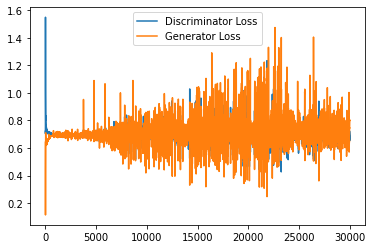

In [ ]:
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.legend()
plt.show()